In [40]:
%matplotlib inline
import numpy as np
from scipy.stats import multivariate_normal, norm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
rc('text', usetex=True)

import os
import pickle

from copy import deepcopy

import tqdm

from sklearn.datasets import make_spd_matrix

In [41]:
outdir = './output/synthetic/univariate/'
if not os.path.exists(outdir):
    os.makedirs(outdir)

outdir_abrupt = './output/synthetic/univariate/abrupt_mixture/'
if not os.path.exists(outdir_abrupt):
    os.makedirs(outdir_abrupt)
    
outdir_gradual = './output/synthetic/univariate/gradual_mixture/'
if not os.path.exists(outdir_gradual):
    os.makedirs(outdir_gradual)

In [42]:
class Theta:
    def __init__(self, pi, mu, sigma):
        self.pi = pi
        self.mu = mu
        self.sigma = sigma

In [43]:
def compute_tau(X, theta):
    N = X.shape[0]
    K = len(theta.pi)

    tau = np.zeros((N, K))
    for k in range(K):
        d_k = norm(theta.mu[k], theta.sigma[k])
        for i in range(N):
            tau[i, k] = theta.pi[k] * d_k.pdf(X[i])
    
    tau /= np.sum(tau, axis=1, keepdims=True)
    
    return tau

In [44]:
def compute_stat(X, Z):
    K = Z.shape[0]
    D = X.shape[1]

    s1 = np.sum(Z, axis=0)
    s2 = X.T.dot(Z).ravel()
    s3 = (X**2).T.dot(Z).ravel()
    
    return s1, s2, s3

In [45]:
def step_M(s, x, eps=1e-8):
    pi = (s.s1 + eps) / (1.0 + eps * len(s.s1))
    mu = s.s2 / (s.s1 + eps)
    sigma = np.sqrt(s.s3 / (s.s1 + eps) - mu**2)
    return pi, mu, sigma

In [46]:
class SuffStat:
    def __init__(self):
        pass

In [47]:
class SuffStatGMM(SuffStat):
    def __init__(self, K, D, seed=0):
        super().__init__()
        np.random.seed(seed)
        self.s1 = np.random.random(K)
        self.s2 = np.random.random(K)
        self.s3 = np.random.random(K)

In [48]:
def sra(X, theta0, rho, gamma):
    K = len(theta0.mu)
    N = X.shape[0]
    
    theta_est = np.zeros((N, 3*K+1))
    theta = deepcopy(theta0)
    
    s = SuffStatGMM(len(theta0.pi), 1)
    
    # initialization
    tau = compute_tau(X[:10, :], theta)
    s.s1[:], s.s2[:], s.s3[:] = compute_stat(X[:10, :], tau)
    
    inds = np.arange(N)
    
    for n in range(N):
        ind_n = inds[n]
        
        tau_indiv_new = compute_tau(X[ind_n, :], theta).ravel()
        s2_indiv_new = X[ind_n, :] * tau_indiv_new
        s3_indiv_new = X[ind_n, :]**2 * tau_indiv_new

        if ( np.any(np.isnan(tau_indiv_new)) | (np.linalg.norm(s2_indiv_new - s.s2) >= gamma) ):
            theta_est[n, :] = np.hstack((n, theta.pi, theta.mu, theta.sigma))
            continue
            
        # update the statistics
        s.s1 += rho[n] * (tau_indiv_new - s.s1)
        s.s2 += rho[n] * (s2_indiv_new - s.s2)
        s.s3 += rho[n] * (s3_indiv_new - s.s3)
                
        # M-step
        theta.pi[:], theta.mu[:], theta.sigma[:] = step_M(s, X[ind_n, :])
        theta_est[n, :] = np.hstack((n, theta.pi, theta.mu, theta.sigma))

    return theta_est

In [49]:
def generate_data(N, pi, mu, sigma):
    
    z_list = np.random.choice(np.arange(len(pi)), N, replace=True)
    
    X = np.zeros((N, 1))
    for i, z in enumerate(z_list):
        X_i = np.random.normal(mu[z], sigma[z])
        X[i, :] = X_i
    
    return X

In [50]:
from matplotlib import gridspec
def create_subtitle(fig: plt.Figure, grid: gridspec.SubplotSpec, title: str, fontsize: int=16):
    row = fig.add_subplot(grid)
    # the '\n' is importantf
    row.set_title(f'{title}\n', fontweight='semibold', fontsize=fontsize)
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

In [51]:
pi = np.array([0.2, 0.8])
pi0 = pi.copy()

sigma = np.array([0.1, 0.1])
sigma0 = np.array([0.2, 0.2])

mu0 = [0.1, -0.1]

theta0 = Theta(pi0, mu0, sigma0)

seed0 = 1
seed = seed0

In [52]:
with open(os.path.join(outdir_abrupt, 'mse_eval.pkl'), 'rb') as f:
    mse_eval_abrupt = pickle.load(f)
    
with open(os.path.join(outdir_abrupt, 'mse_former.pkl'), 'rb') as f:
    mse_former_abrupt = pickle.load(f)
    
with open(os.path.join(outdir_abrupt, 'mse_latter.pkl'), 'rb') as f:
    mse_latter_abrupt = pickle.load(f)
    
with open(os.path.join(outdir_abrupt, 'mse_overall.pkl'), 'rb') as f:
    mse_overall_abrupt = pickle.load(f)

In [53]:
mse_eval_df_abrupt = pd.DataFrame(mse_eval_abrupt[:, ::-1], columns=['0.9', '0.95', '0.99'])
mse_former_df_abrupt = pd.DataFrame(mse_former_abrupt[:, ::-1], columns=['0.9', '0.95', '0.99'])
mse_latter_df_abrupt = pd.DataFrame(mse_latter_abrupt[:, ::-1], columns=['0.9', '0.95', '0.99'])
mse_overall_df_abrupt = pd.DataFrame(mse_eval_abrupt[:, ::-1], columns=['0.9', '0.95', '0.99'])

In [54]:
mse_eval_df_melt_abrupt = mse_eval_df_abrupt.melt()
mse_former_df_melt_abrupt = mse_former_df_abrupt.melt()
mse_latter_df_melt_abrupt = mse_latter_df_abrupt.melt()
mse_overall_df_melt_abrupt = mse_overall_df_abrupt.melt()

In [55]:
with open(os.path.join(outdir_gradual, 'mse_eval.pkl'), 'rb') as f:
    mse_eval_gradual = pickle.load(f)
    
with open(os.path.join(outdir_gradual, 'mse_former.pkl'), 'rb') as f:
    mse_former_gradual = pickle.load(f)
    
with open(os.path.join(outdir_gradual, 'mse_latter.pkl'), 'rb') as f:
    mse_latter_gradual = pickle.load(f)
    
with open(os.path.join(outdir_gradual, 'mse_overall.pkl'), 'rb') as f:
    mse_overall_gradual = pickle.load(f)

In [56]:
mse_eval_df_gradual = pd.DataFrame(mse_eval_gradual[:, ::-1], columns=['0.9', '0.95', '0.99'])
mse_former_df_gradual = pd.DataFrame(mse_former_gradual[:, ::-1], columns=['0.9', '0.95', '0.99'])
mse_latter_df_gradual = pd.DataFrame(mse_latter_gradual[:, ::-1], columns=['0.9', '0.95', '0.99'])
mse_overall_df_gradual = pd.DataFrame(mse_eval_gradual[:, ::-1], columns=['0.9', '0.95', '0.99'])

In [57]:
mse_eval_df_melt_gradual = mse_eval_df_gradual.melt()
mse_former_df_melt_gradual = mse_former_df_gradual.melt()
mse_latter_df_melt_gradual = mse_latter_df_gradual.melt()
mse_overall_df_melt_gradual = mse_overall_df_gradual.melt()

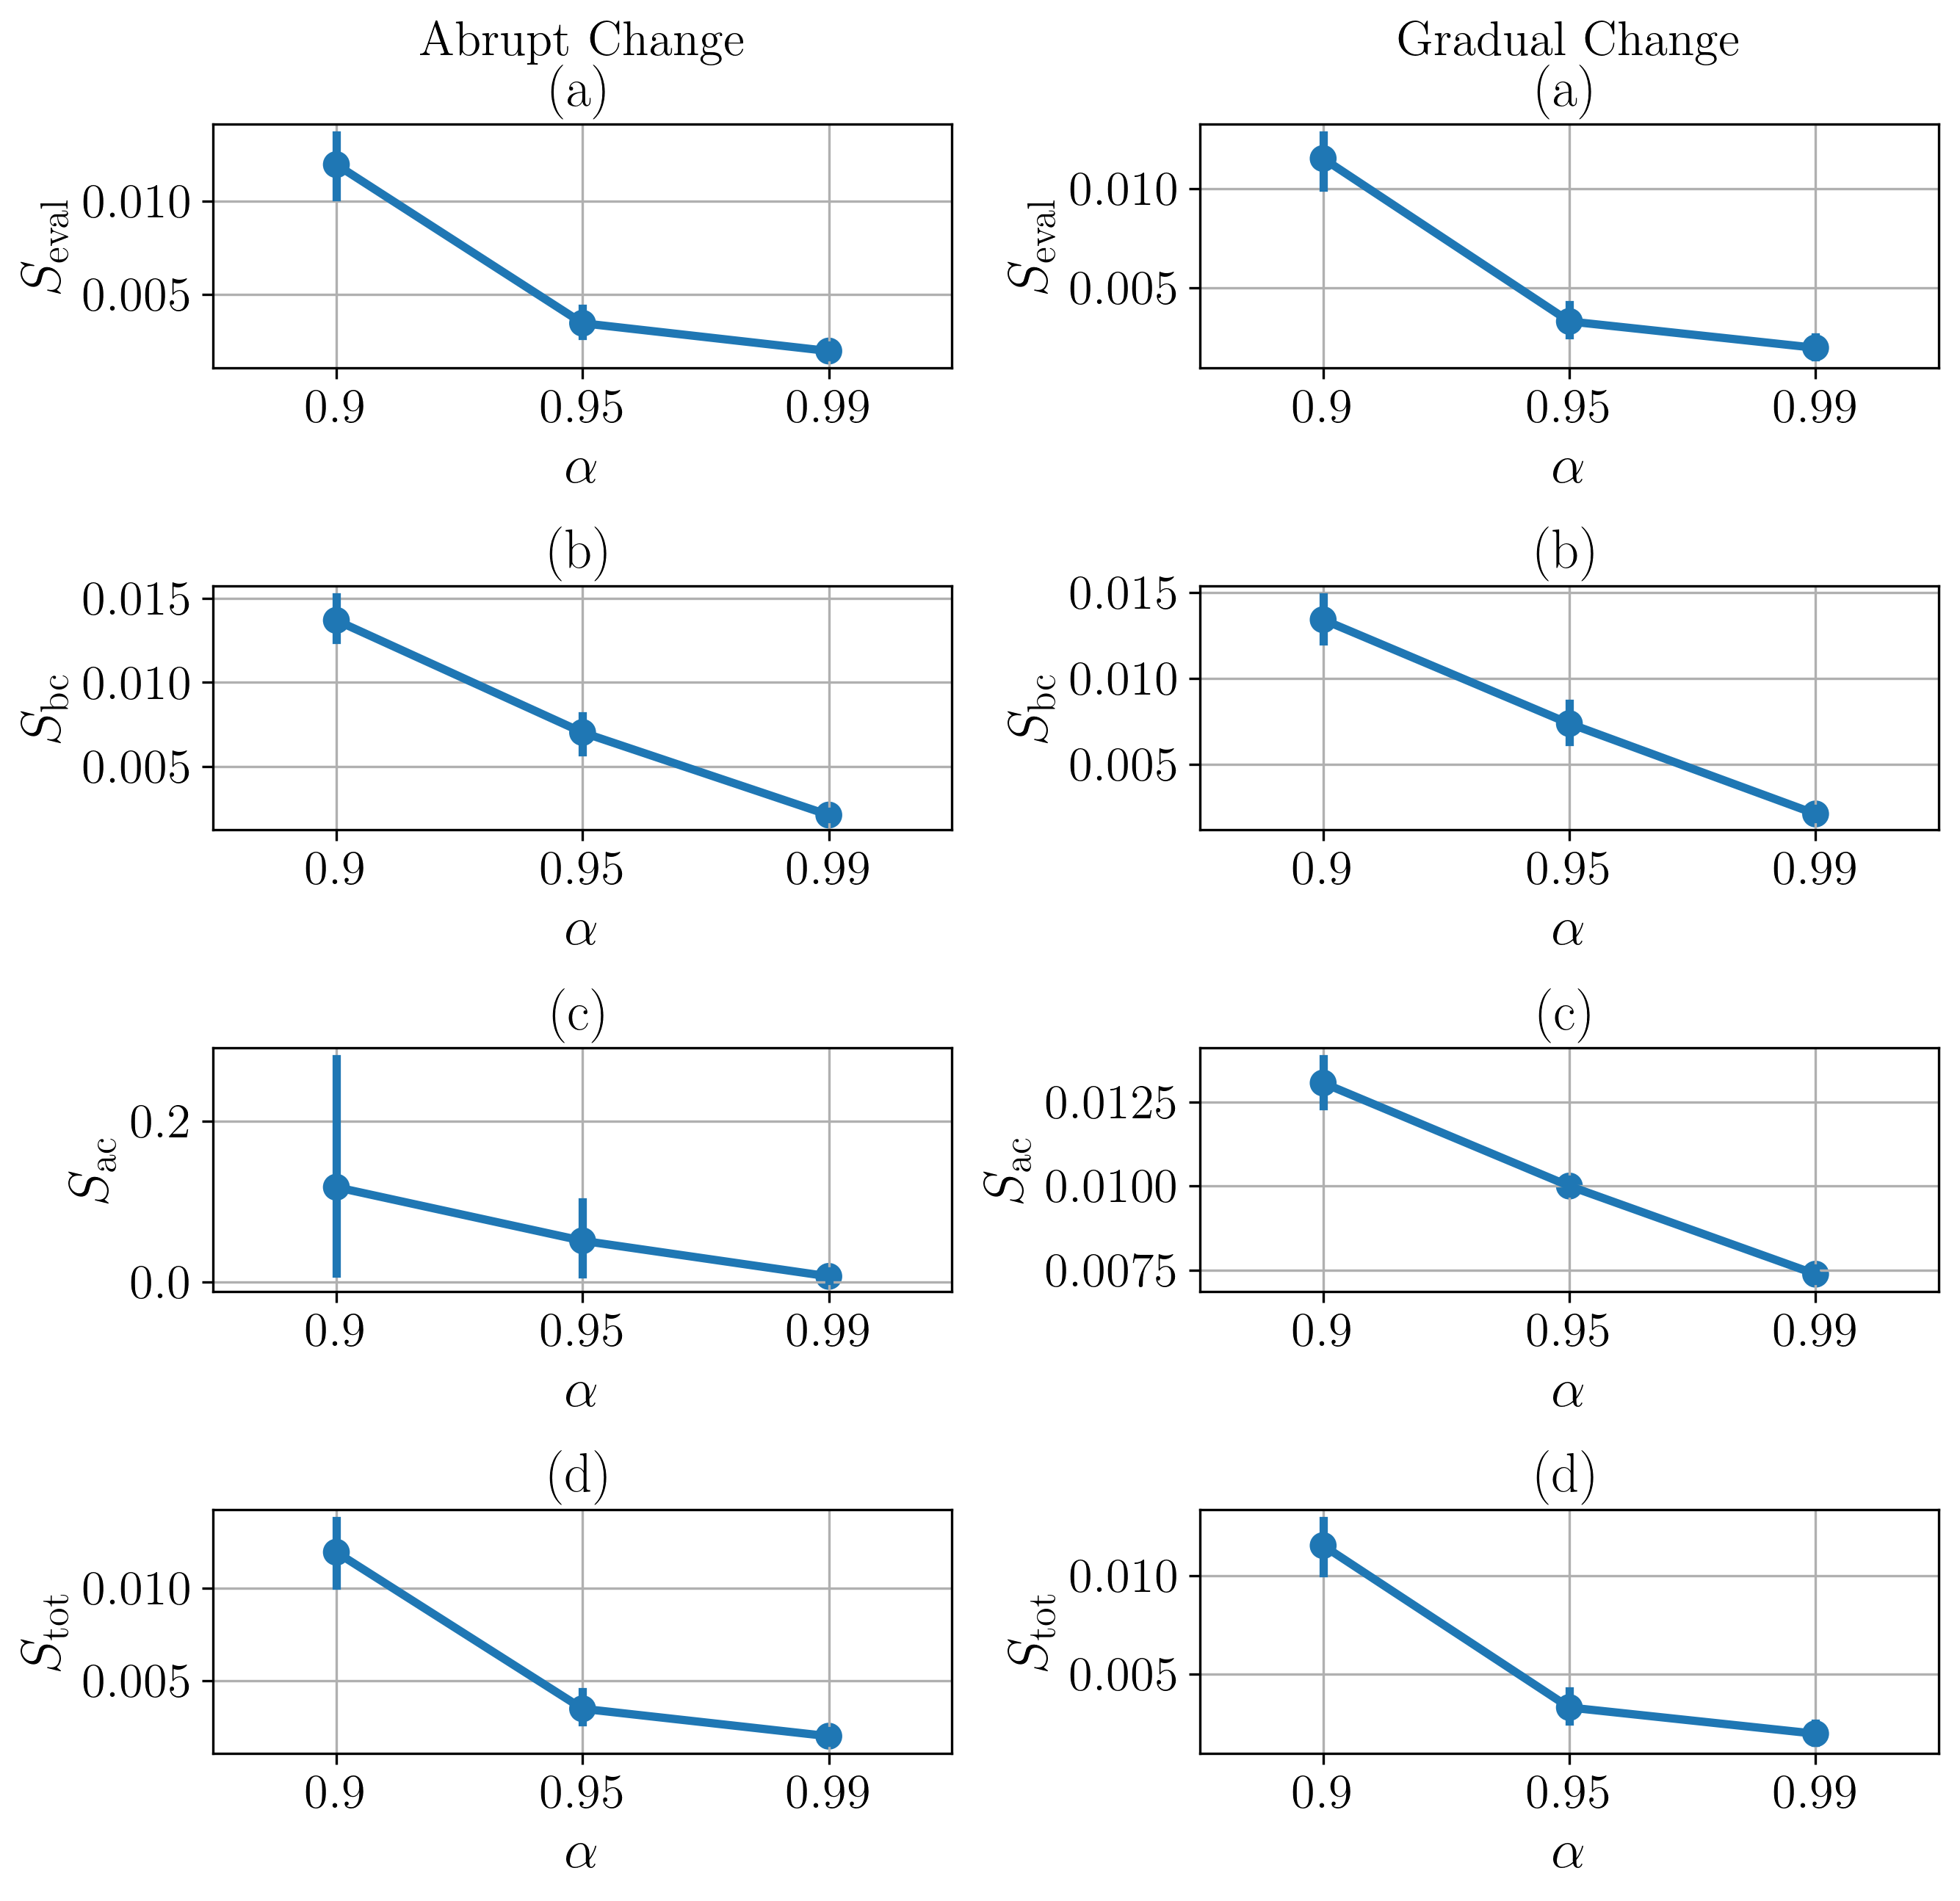

In [60]:
fig, axes = plt.subplots(4, 2, sharex=True, figsize=(9, 9), dpi=300)

sns.pointplot(data=mse_eval_df_melt_abrupt, x='variable', y='value', ax=axes[0, 0])
sns.pointplot(data=mse_former_df_melt_abrupt, x='variable', y='value', ax=axes[1, 0])
sns.pointplot(data=mse_latter_df_melt_abrupt, x='variable', y='value', ax=axes[2, 0])
sns.pointplot(data=mse_overall_df_melt_abrupt, x='variable', y='value', ax=axes[3, 0])

axes[0, 0].grid()
axes[0, 0].set_title('(a)', fontsize=18)
axes[0, 0].set_xlabel(r'$\alpha$', fontsize=18)
axes[0, 0].set_ylabel(r'$S_{\mathrm{eval}}$', fontsize=18)
axes[0, 0].xaxis.set_tick_params(which='both', labelbottom=True)

axes[1, 0].grid()
axes[1, 0].set_title('(b)', fontsize=18)
axes[1, 0].set_xlabel(r'$\alpha$', fontsize=18)
axes[1, 0].set_ylabel(r'$S_{\mathrm{bc}}$', fontsize=18)
axes[1, 0].xaxis.set_tick_params(which='both', labelbottom=True)

axes[2, 0].grid()
axes[2, 0].set_title('(c)', fontsize=18)
axes[2, 0].set_xlabel(r'$\alpha$', fontsize=18)
axes[2, 0].set_ylabel(r'$S_{\mathrm{ac}}$', fontsize=18)
axes[2, 0].xaxis.set_tick_params(which='both', labelbottom=True)

axes[3, 0].grid()
axes[3, 0].set_title('(d)', fontsize=18)
axes[3, 0].set_xlabel(r'$\alpha$', fontsize=18)
axes[3, 0].set_ylabel(r'$S_{\mathrm{tot}}$', fontsize=18)
axes[3, 0].xaxis.set_tick_params(which='both', labelbottom=True)

plt.rc('font', family='serif')
axes[3, 0].set_xticklabels([0.9, 0.95, 0.99])

sns.pointplot(data=mse_eval_df_melt_gradual, x='variable', y='value', ax=axes[0, 1])
sns.pointplot(data=mse_former_df_melt_gradual, x='variable', y='value', ax=axes[1, 1])
sns.pointplot(data=mse_latter_df_melt_gradual, x='variable', y='value', ax=axes[2, 1])
sns.pointplot(data=mse_overall_df_melt_gradual, x='variable', y='value', ax=axes[3, 1])

axes[0, 1].grid()
axes[0, 1].set_title('(a)', fontsize=18)
axes[0, 1].set_xlabel(r'$\alpha$', fontsize=18)
axes[0, 1].set_ylabel(r'$S_{\mathrm{eval}}$', fontsize=18)
axes[0, 1].xaxis.set_tick_params(which='both', labelbottom=True)

axes[1, 1].grid()
axes[1, 1].set_title('(b)', fontsize=18)
axes[1, 1].set_xlabel(r'$\alpha$', fontsize=18)
axes[1, 1].set_ylabel(r'$S_{\mathrm{bc}}$', fontsize=18)
axes[1, 1].xaxis.set_tick_params(which='both', labelbottom=True)

axes[2, 1].grid()
axes[2, 1].set_title('(c)', fontsize=18)
axes[2, 1].set_xlabel(r'$\alpha$', fontsize=18)
axes[2, 1].set_ylabel(r'$S_{\mathrm{ac}}$', fontsize=18)
axes[2, 1].xaxis.set_tick_params(which='both', labelbottom=True)

axes[3, 1].grid()
axes[3, 1].set_title('(d)', fontsize=18)
axes[3, 1].set_xlabel(r'$\alpha$', fontsize=18)
axes[3, 1].set_ylabel(r'$S_{\mathrm{tot}}$', fontsize=18)
axes[3, 1].xaxis.set_tick_params(which='both', labelbottom=True)

plt.rc('font', family='serif')
axes[3, 0].set_xticklabels([0.9, 0.95, 0.99])
axes[3, 1].set_xticklabels([0.9, 0.95, 0.99])

for ax in axes.flat:
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16)

plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)

grid = plt.GridSpec(4, 2)
create_subtitle(fig, grid[0, 0], 'Abrupt Change')
create_subtitle(fig, grid[0, 1], 'Gradual Change')

plt.tight_layout()
plt.savefig(os.path.join(outdir, 'dependency_on_alpha.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(outdir, 'dependency_on_alpha.eps'), bbox_inches='tight')
plt.savefig(os.path.join(outdir, 'dependency_on_alpha.png'), bbox_inches='tight')